# Goodreads Book Reviews

In [1]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Loading Data

In [2]:
#importing packages
import tqdm
import re
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import pickle

In [3]:
#set directory for loading dataset
DIR = './goodreads-master/'

In [4]:
#function to preview or read in the data the data
#takes each line to a list and then appends to a list to make a list of lists
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            data_list = []
            data_list.append(d['user_id'])
            data_list.append(d['book_id'])
            data_list.append(d['review_id'])
            data_list.append(d['rating'])
            data_list.append(d['review_text'])
            if r'(view spoiler)' in d['review_text']:
                data_list.append(1)
            else: data_list.append(0)
            data.append(data_list)
            count += 1
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [5]:
#load in raw text (this will probably a little while)
data = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'), head = None)

In [6]:
#take the list of lists to DF

df = pd.DataFrame(data, columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'spoiler'])
print(df.review_id.nunique())

df.set_index('review_id', inplace = True)
print('')
df.info()


1378033

<class 'pandas.core.frame.DataFrame'>
Index: 1378033 entries, dfdbb7b0eb5a7e4c26d59a937e2e5feb to 62ed1263c7d216986cc419cd4e8a408b
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1378033 non-null  object
 1   book_id      1378033 non-null  object
 2   rating       1378033 non-null  int64 
 3   review_text  1378033 non-null  object
 4   spoiler      1378033 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 63.1+ MB


In [7]:
#remove data from memory
del(data)

## Early Data Exploration

In [8]:
#previewing the data
df.head(10)

,user_id,book_id,rating,review_text,spoiler
review_id,,,,,
dfdbb7b0eb5a7e4c26d59a937e2e5feb,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...,1
a5d2c3628987712d0e05c4f90798eb67,8842281e1d1347389f2ab93d60773d4d,16981,3,Recommended by Don Katz. Avail for free in Dec...,0
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ...",1
ced5675e55cd9d38a524743f5c40996e,8842281e1d1347389f2ab93d60773d4d,27161156,0,Recommended reading to understand what is goin...,0
332732725863131279a8e345b63ac33e,8842281e1d1347389f2ab93d60773d4d,25884323,4,"I really enjoyed this book, and there is a lot...",1
ea4a220b10e6b5c796dae0e3b970aff1,8842281e1d1347389f2ab93d60773d4d,19398490,4,A beautiful story. It is rare to encounter a b...,0
5fe9882bfe4b0520a322820c4c55747d,8842281e1d1347389f2ab93d60773d4d,22318578,5,5 stars for giving me a better framework for h...,0
dbc01e2438df7a87ee3dc16ee23a53e5,8842281e1d1347389f2ab93d60773d4d,24189224,0,Numerous people in publishing have told me thi...,0
754710070f38e1c59a45f6a85473b836,8842281e1d1347389f2ab93d60773d4d,22551730,4,Another hard to put down nonfiction book from ...,0


In [9]:
df.rating.value_counts()

4    480199
5    403374
3    290430
2    112226
0     47052
1     44752
Name: rating, dtype: int64

I was not expecting the 0 score for reviews. Let's take a look.

**Not necessary to rerun**

In [9]:
#list of 0 scored reviews
review_text0 = [df.review_text.iloc[i] for i in range(len(df.review_text)) if df.rating.iloc[i] == 0]

In [10]:
#random sample to examine data
np.random.choice(review_text0)

'Her books are always the cutest! Well written, good humor and flow...Hope the next one will come out soon!'

Reviews with 0 stars often appear to be from people who did not finish the book or were in the process of reading. However, they can also be legitimate reviews. They are sometimes negative or positive, but are most often neutral. Goodreads allows you to review without setting the stars, so these reviews should likely be thrown out for prediction purposes.

In [11]:
#remove from memory
del(review_text0)

## Data Cleaning

In [10]:
#removing the 0 ratings
df = df.loc[df.rating != 0]
len(df)

1330981

In [11]:
#remove those reviews of under 100 characters for computational speed purposes
df = df.loc[(df.review_text.astype(str).str.len()) >= 100]
len(df)

1175005

In [12]:
#number of unique users
df.user_id.nunique()

18833

In [13]:
#number of unique books
df.book_id.nunique()

25466

In [14]:
#mapping the 5 starts to negative, neutral, positive
df.rating = df.rating.map({1 : -1, 2 : -1, 3 : 0, 4 : 1, 5: 1})
df.rating.value_counts()

 1    771529
 0    261806
-1    141670
Name: rating, dtype: int64

In [15]:
#building out a normalization dict to perform prior to stemming
normalization_dict = {'was' : 'be', 'is' : 'be', 'are': 'be', 'been': 'be', 'were': 'be', 'am' : 'be', 
                      'wasnt':'isnt', 'was not':'isnt', 'are not':'isnt', 'arent':'isnt', 'werent':'isnt', 'were not':'isnt',
                      'so': '', 'such':'', 'the' : '', 'a': '', 'an' : '', 'to': '', 'of':'', 'in':''}

In [19]:
#writing a preprocessing and normalization function

from nltk.stem import PorterStemmer
 
# init stemmer
porter_stemmer=PorterStemmer()
 
def basic_preprocessor(text):
    text = re.sub(r"(view spoiler)|(hide spoiler)|\n", "", text) #removing view spoiler, hide spoiler and newline char
    
    text=text.lower() #lower case text
    
    text = re.sub("[^a-z0-9 ]+", "", text) #remove everything except letters and numbers, and spaces (can replace with blank)
    
    #split out words for our list comprehension
    words=re.split("\\s+",text)
    
    #use the normalization words
    normalization_words = [normalization_dict[word] if word in normalization_dict.keys() else word for word in words]
    
    # stem words
    stemmed_words=[porter_stemmer.stem(word=word) for word in normalization_words]
        
    return ' '.join(stemmed_words)

**Be careful of processing time below. DO NOT RERUN**

In [17]:
#preprocessing text
df.review_text = [basic_preprocessor(text) for text in df.review_text]

In [18]:
#checking preprocessing
df.review_text[0]

'thi be  special book it start slow for about  first third then   middl third it start  get interest then  last third blew my mind thi be what i love about good scienc fiction it push your think about where thing can go it be  2015 hugo winner and translat from it origin chines which made it interest  just  differ way from most thing ive read for instanc  intermix  chines revolutionari histori how they kept accus peopl  be reactionari etc it be  book about scienc and alien  scienc describ   book be impress it  book ground  physic and pretti accur as far as i could tell though when it got  fold proton into 8 dimens i think he be just make stuff up interest  think about though but what would happen if our seti station receiv  messag if we found someon be out there and  person monitor and answer  signal on our side be disillus that part   book be  bit dark i would like  think human reaction  discov alien civil that be hostil would be more like ender game where we would band togeth i did l

In [20]:
#pickling the preprocessed text
with open("preprocessed_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

In [67]:
#unpickle the preprocessed text list (loading from file)
with open("preprocessed_text.txt", "rb") as fp:   # Unpickling
    df.review_text = pickle.load(fp)

## Splitting Data Prior to Feature Creation/Engineering

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['rating', 'user_id', 'book_id'], axis = 1), 
                                                    df.rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(940004, 2) (940004,)
(235001, 2) (235001,)


In [22]:
#remove df from memory
del(df)

In [23]:
#Count Vectorizer or tfidf_vectorizer?
#I use 20% because only using bigrams due to memory constraints (would use 25 - 30% if included 1-grams)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df = 0.20, min_df = 180, ngram_range = (2,2),
                                  lowercase = False)

In [24]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(X_train.review_text)

In [25]:
#pickling the results
with open("tfidf_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_train, fp)

In [49]:
#unpickle the results
with open("tfidf_vectors_train.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_train = pickle.load(fp)

In [26]:
tfidf_vectors_test = tfidf_vectorizer.transform(X_test.review_text)

In [27]:
#pickling the results
with open("tfidf_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_test, fp)

In [50]:
#unpickle the results
with open("tfidf_vectors_test.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_test = pickle.load(fp)

In [28]:
len(tfidf_vectorizer.vocabulary_)

92349

In [29]:
tfidf_vectors_train.shape

(940004, 92349)

In [30]:
#checking if some expected words are in our vocab to deterime if 20% is an OK cutoff for frequency
tfidf_vectorizer.vocabulary_['isnt it']

43604

In [31]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).iloc[:10]

,idf_weights
but it,2.756889
she be,2.790850
and it,2.819770
be not,2.830050
for me,2.882873
and be,2.932473
he be,2.949958
read thi,2.959265
they be,2.979914
be just,2.983951


In [33]:
feature_names = tfidf_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tfidf_vectors_train[0]
 
#print the scores
df1 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
toward book,0.183966
whi mayb,0.180839
isnt rush,0.180372
later im,0.180142
five page,0.175559
get introduc,0.171747
be neg,0.170933
her kill,0.169195
kill or,0.165856
introduc charact,0.163612


In [35]:
del(df1)

## Reducing Dimensionality

In [54]:
#using truncated SVD to reduce dimensionality further
#truncated SVD can take sparse matricies which is important due to memory constraints
from sklearn.decomposition import TruncatedSVD

#sklearn recommends 100 components for LSA, but it hurt model accuracy by > 5%
svd = TruncatedSVD(n_components=200, n_iter=10, random_state=42)

**Be careful of calc time**

In [55]:
SVD_train = svd.fit_transform(X = tfidf_vectors_train, y = y_train)

In [56]:
#pickling the results
with open("SVD_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_train, fp)

In [ ]:
#unpickle the results
with open("SVD_train.pkl", "rb") as fp:   # Unpickling
    SVD_train = pickle.load(fp)

In [57]:
SVD_test = svd.transform(X = tfidf_vectors_test)

In [58]:
#pickling the results
with open("SVD_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_test, fp)

In [ ]:
#unpickle the results
with open("SVD_test.pkl", "rb") as fp:   # Unpickling
    SVD_test = pickle.load(fp)

In [59]:
type(SVD_train)

numpy.ndarray

In [60]:
SVD_train.shape

(940004, 200)

In [64]:
#keeping memory cleared out
del(X_train, X_test, tfidf_vectors_train, tfidf_vectors_test)

## Modeling the Sentiment

### Logistic Regression

#### Baseline Sentiment Prediction (SVD features only)

In [65]:
#logistic regression model

from sklearn.linear_model import LogisticRegression

scikit_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=45, C=1, penalty='l2', max_iter=300, n_jobs = -1)

In [66]:
#only using SVD features
model = scikit_log_reg.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 23.6min finished


In [67]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.7364
       F-score:     0.7119
      Log Loss:     0.6093


In [72]:
del(model)

#### Tuning

In [70]:
from sklearn.linear_model import LogisticRegressionCV
cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=300, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 53)

In [75]:
logit_model = cv.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 39.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 39.1min finished


In [ ]:
del(logit_model)

In [82]:
#best C was 100
scikit_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=53, C=100, penalty='l2', max_iter=300, n_jobs = -1)
model = scikit_log_reg.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 16.6min finished


In [83]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.7372
       F-score:     0.7138
      Log Loss:     0.6089


In [84]:
#pickling the model
with open("logit_model.pkl", "wb") as fp:   #Pickling
    pickle.dump(model, fp)

In [ ]:
#unpickle the model (loading from file)
with open("logit_model.pkl", "rb") as fp:   # Unpickling
    model = pickle.load(fp)

C:\Users\dwit3\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\dwit3\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


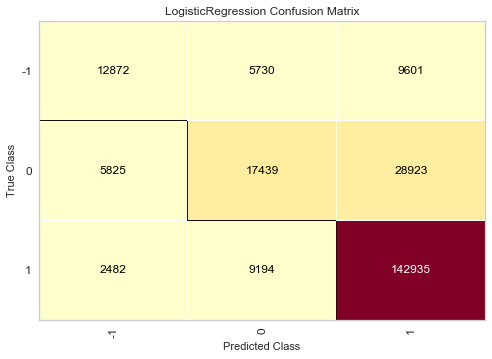

In [86]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(SVD_train, y_train)
knn_cm.score(SVD_test, y_test)

knn_cm.show()

C:\Users\dwit3\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


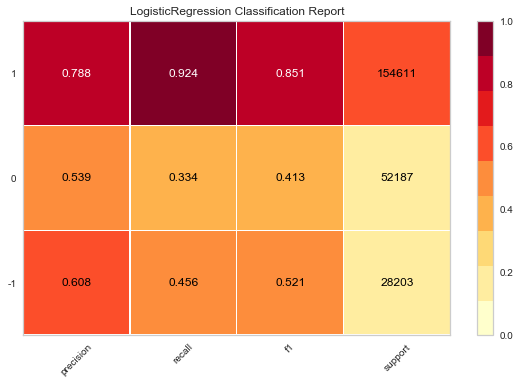

In [88]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(SVD_train, y_train)        # Fit the visualizer and the model
visualizer.score(SVD_test, y_test)        # Evaluate the model on the test data
visualizer.show()

